In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset/weather_dataset.csv


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=8b39e3c5435ac613c6cbb9330400c64376fd0afceec3c76ab4df989a77765188
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassificationModel
import os

# Initialize Spark Session
spark = SparkSession.builder.appName('weather_prediction').getOrCreate()

# Load the dataset
file_path = '/kaggle/input/weather-dataset/weather_dataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/20 14:31:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from scipy import stats

# Selecting categorical columns
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

# Function to calculate ANOVA F-statistic and p-value
def anova_test(df, categorical_column, numerical_column='precipMM'):
    categories = df.select(categorical_column).distinct().rdd.flatMap(lambda x: x).collect()
    if len(categories) < 2:
        return None
    
    # Calculating the overall mean
    overall_mean = df.select(mean(numerical_column)).collect()[0][0]
    
    # Calculating the within-group and between-group sum of squares
    sum_squares_between = sum([
        df.filter(col(categorical_column) == cat).count() * 
        (df.filter(col(categorical_column) == cat).select(mean(numerical_column)).collect()[0][0] - overall_mean) ** 2 
        for cat in categories
    ])

    sum_squares_within = sum([
        df.filter(col(categorical_column) == cat).select(F.variance(numerical_column)).collect()[0][0] *
        (df.filter(col(categorical_column) == cat).count() - 1)
        for cat in categories
    ])

    # Degrees of freedom
    df_between = len(categories) - 1
    df_within = df.count() - len(categories)

    # Calculating the F-statistic
    mean_square_between = sum_squares_between / df_between
    mean_square_within = sum_squares_within / df_within
    f_statistic = mean_square_between / mean_square_within

    # P-Value (using approximation)
    p_value = 1 - stats.f.cdf(f_statistic, df_between, df_within)

    return (categorical_column, f_statistic, p_value)

# Limit the DataFrame to the first 5000 rows
df_limit = df.limit(500)

# Applying ANOVA test for each categorical column
anova_results = [anova_test(df_limit, column) for column in categorical_columns if anova_test(df_limit, column) is not None]
# Convert results to Spark DataFrame
anova_results_converted = [(col, float(f_stat), float(p_val)) for col, f_stat, p_val in anova_results]

# Define the schema
from pyspark.sql.types import StructType, StructField, FloatType, StringType

# Create DataFrame using the converted results
schema = StructType([
    StructField("Column", StringType(), True),
    StructField("F-statistic", FloatType(), True),
    StructField("P-value", FloatType(), True)
])

anova_df = spark.createDataFrame(anova_results_converted, schema)

# Filter and Sort Results
significant_results = anova_df.filter(col('P-value') <= 0.05).sort('F-statistic', ascending=False)

# Show Results
significant_results.show()


+--------------+-----------+------------+
|        Column|F-statistic|     P-value|
+--------------+-----------+------------+
|       predict|  177.93175|1.110223E-16|
|   weatherDesc|  123.76882|1.110223E-16|
|weatherIconUrl|   62.73706|1.110223E-16|
|      moonrise|  7.1725593|1.110223E-16|
|       moonset|  7.1725593|1.110223E-16|
|       sunrise|   7.107449|4.2002156E-8|
|    moon_phase|  3.2980402| 0.003425629|
+--------------+-----------+------------+



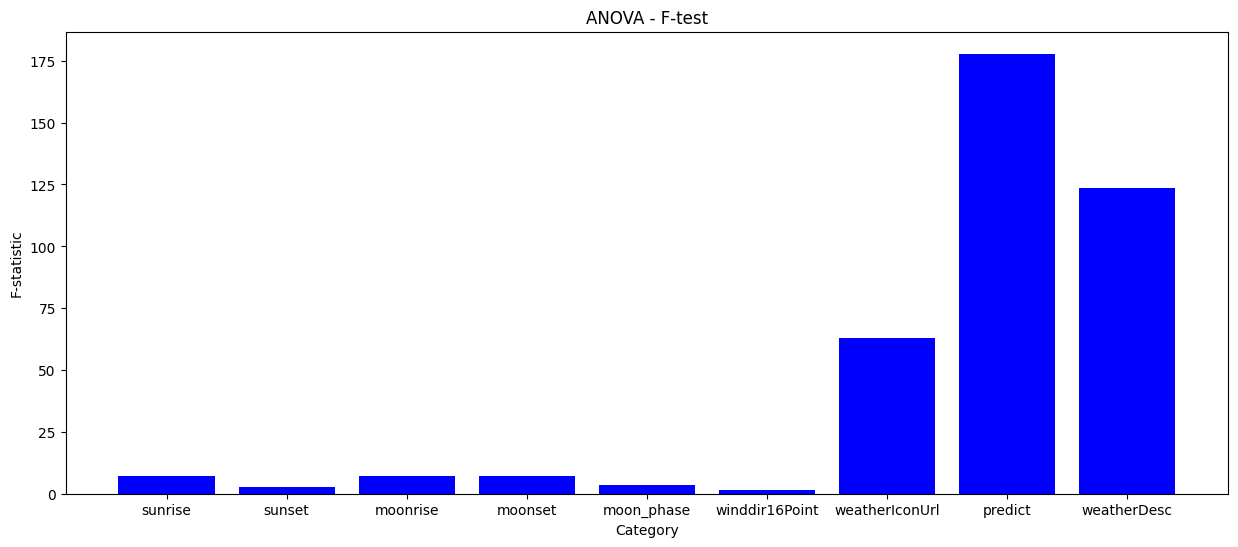

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Your existing code for ANOVA
# ...

# Convert the ANOVA results list to a DataFrame
anova_df = pd.DataFrame(anova_results, columns=['Column', 'F-statistic', 'P-value'])

# Vẽ biểu đồ cột cho F-statistic
plt.figure(figsize=(15, 6))
plt.bar(anova_df['Column'], anova_df['F-statistic'], color='blue')
plt.title('ANOVA - F-test')
plt.xlabel('Category')
plt.ylabel('F-statistic')
plt.show()


Chọn 3 cột predict, weatherDesc, weatherIconUrl có ảnh hưởng đến precipMM.

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from scipy import stats

def find_significant_vars_spark(df, target_var, alpha=0.05):
    numeric_vars = [col_name for col_name, data_type in df.dtypes if data_type in ['double', 'int']]
    numeric_vars.remove(target_var)

    significant_vars = []

    for var in numeric_vars:
        correlation = df.stat.corr(var, target_var)
        p_value = stats.pearsonr(df.select(var).rdd.flatMap(lambda x: x).collect(),
                                 df.select(target_var).rdd.flatMap(lambda x: x).collect())[1]

        if p_value < alpha:
            significant_vars.append({
                'Column': var,
                'F-statistic': correlation,
                'P-value': p_value
            })

    return significant_vars

find_significant_vars_spark(df, 'precipMM')
# Gọi hàm và lưu kết quả vào một biến
significant_vars_output = find_significant_vars_spark(df, 'precipMM')

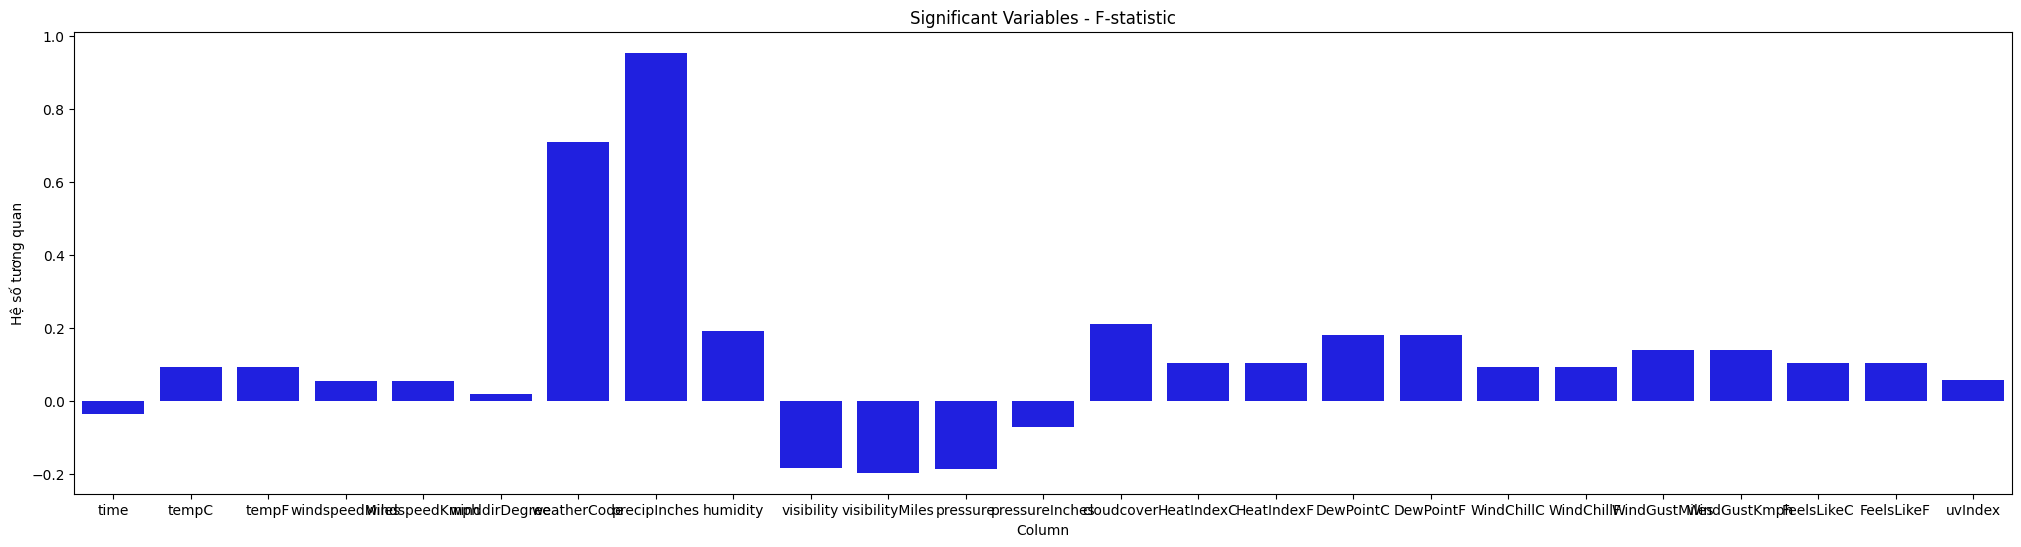

In [7]:
# Tạo DataFrame từ kết quả
significant_variables_df = pd.DataFrame(significant_vars_output)

# Vẽ biểu đồ
plt.figure(figsize=(25, 6))
sns.barplot(x='Column', y='F-statistic', data=significant_variables_df, color='blue')
plt.title('Significant Variables - F-statistic')
plt.ylabel('Hệ số tương quan')
plt.show()


Chọn 2 cột weatherCode và precipInches.

In [8]:
# Split the data into training and test sets
# Chia bộ dữ liệu thành hai phần: dữ liệu huấn luyện và dữ liệu kiểm thử.
train_data, test_data = df.randomSplit([0.8, 0.2])

In [9]:
# Selecting relevant columns and dropping rows with missing values
# Chọn ra các cột dữ liệu liên quan và loại bỏ những hàng có giá trị thiếu.
selected_columns = ['predict', 'weatherDesc', 'weatherIconUrl','precipMM','weatherCode','precipInches' ]
df = df.select(selected_columns).na.drop()

In [10]:
# Indexing the label column
indexer = StringIndexer(inputCol='predict', outputCol='predictId')
predictStringIndexer = indexer.fit(df)
df = predictStringIndexer.transform(df)

In [11]:
indexer = StringIndexer(inputCol='weatherDesc', outputCol='weatherDescId')
weatherDescStringIndexer = indexer.fit(df)
df = weatherDescStringIndexer.transform(df)

In [12]:
indexer = StringIndexer(inputCol='weatherIconUrl', outputCol='weatherIconUrlId')
weatherIconUrlStringIndexer = indexer.fit(df)
df = weatherIconUrlStringIndexer.transform(df)

In [13]:
indexer = StringIndexer(inputCol='precipMM', outputCol='label')
precipMMStringIndexer = indexer.fit(df)
df = precipMMStringIndexer.transform(df)

In [14]:
df.show()

+-------+--------------------+--------------------+--------+-----------+------------+---------+-------------+----------------+-----+
|predict|         weatherDesc|      weatherIconUrl|precipMM|weatherCode|precipInches|predictId|weatherDescId|weatherIconUrlId|label|
+-------+--------------------+--------------------+--------+-----------+------------+---------+-------------+----------------+-----+
|   rain|Patchy rain possible|[{'value': 'https...|     0.2|        176|         0.0|      1.0|          1.0|             6.0|  1.0|
|no rain|       Partly cloudy|[{'value': 'https...|     0.0|        116|         0.0|      0.0|          0.0|             0.0|  0.0|
|no rain|       Partly cloudy|[{'value': 'https...|     0.0|        116|         0.0|      0.0|          0.0|             0.0|  0.0|
|no rain|              Cloudy|[{'value': 'https...|     0.0|        119|         0.0|      0.0|          2.0|             1.0|  0.0|
|no rain|              Cloudy|[{'value': 'https...|     0.0|        1

In [15]:
# lưu lại StringIndexer
# indexer_model.write().overwrite().save("/kaggle/working/StringIndexer")

In [16]:
df.select('precipMM', 'weatherDescId','predictId','weatherIconUrlId', 'label' ).distinct().show()

+--------+-------------+---------+----------------+-----+
|precipMM|weatherDescId|predictId|weatherIconUrlId|label|
+--------+-------------+---------+----------------+-----+
|     4.5|          6.0|      1.0|             7.0| 43.0|
|     3.5|          6.0|      1.0|             7.0| 35.0|
|     2.3|          6.0|      1.0|             8.0| 23.0|
|     1.9|          6.0|      1.0|             7.0| 19.0|
|    13.1|          6.0|      1.0|             7.0|128.0|
|     5.3|          6.0|      1.0|             7.0| 54.0|
|    10.9|          6.0|      1.0|             7.0|113.0|
|     4.4|          6.0|      1.0|             8.0| 45.0|
|     0.9|          7.0|      1.0|             8.0| 10.0|
|     2.2|          6.0|      1.0|             8.0| 22.0|
|     1.5|          6.0|      1.0|             8.0| 14.0|
|     6.1|          6.0|      1.0|             8.0| 56.0|
|    17.4|          6.0|      1.0|             8.0|151.0|
|    11.0|          6.0|      1.0|             8.0| 87.0|
|     3.9|    

In [17]:
# Assembling the features
# Tạo vector đặc trưng (features) từ các cột dữ liệu .
assembler = VectorAssembler(inputCols=['predictId', 'weatherDescId', 'weatherIconUrlId','weatherCode','precipInches'], outputCol='features')
df = assembler.transform(df)

In [18]:
df.show()

+-------+--------------------+--------------------+--------+-----------+------------+---------+-------------+----------------+-----+--------------------+
|predict|         weatherDesc|      weatherIconUrl|precipMM|weatherCode|precipInches|predictId|weatherDescId|weatherIconUrlId|label|            features|
+-------+--------------------+--------------------+--------+-----------+------------+---------+-------------+----------------+-----+--------------------+
|   rain|Patchy rain possible|[{'value': 'https...|     0.2|        176|         0.0|      1.0|          1.0|             6.0|  1.0|[1.0,1.0,6.0,176....|
|no rain|       Partly cloudy|[{'value': 'https...|     0.0|        116|         0.0|      0.0|          0.0|             0.0|  0.0|     (5,[3],[116.0])|
|no rain|       Partly cloudy|[{'value': 'https...|     0.0|        116|         0.0|      0.0|          0.0|             0.0|  0.0|     (5,[3],[116.0])|
|no rain|              Cloudy|[{'value': 'https...|     0.0|        119|    

In [20]:
test_data.show()

24/01/20 14:36:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+--------+--------+--------+--------+---------------+-----------------+----+-----+-----+--------------+-------------+-------------+--------------+-----------+--------------------+------------+--------+----------+---------------+--------+--------------+----------+----------+----------+---------+---------+----------+----------+-------------+------------+----------+----------+-------+-------+--------------------+--------+
|          date_time| sunrise|  sunset|moonrise| moonset|     moon_phase|moon_illumination|time|tempC|tempF|windspeedMiles|windspeedKmph|winddirDegree|winddir16Point|weatherCode|      weatherIconUrl|precipInches|humidity|visibility|visibilityMiles|pressure|pressureInches|cloudcover|HeatIndexC|HeatIndexF|DewPointC|DewPointF|WindChillC|WindChillF|WindGustMiles|WindGustKmph|FeelsLikeC|FeelsLikeF|uvIndex|predict|         weatherDesc|precipMM|
+-------------------+--------+--------+--------+--------+---------------+-----------------+----+-----+-----+------

In [21]:
# Initialize classifiers
# Khởi tạo hai mô hình phân loại: Random Forest và Logistic Regression.
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
lr = LogisticRegression(labelCol='label', featuresCol='features')

In [22]:
# Initialize pipeline
# Xây dựng pipeline cho mỗi mô hình để huấn luyện trên dữ liệu.
pipeline_rf = Pipeline(stages=[predictStringIndexer, weatherDescStringIndexer, weatherIconUrlStringIndexer, precipMMStringIndexer, assembler, rf])
pipeline_lr = Pipeline(stages=[predictStringIndexer, weatherDescStringIndexer, weatherIconUrlStringIndexer, precipMMStringIndexer, assembler, lr])

In [23]:
# Fit the models
# Huấn luyện 2 mô hình
model_rf = pipeline_rf.fit(train_data)
model_lr = pipeline_lr.fit(train_data)

24/01/20 14:36:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [24]:
# Save the Random Forest model
model_rf.save("/kaggle/working/random_forest_model")

In [25]:
# Save the Logistic Regression model
model_lr.save("/kaggle/working/logistic_regression_model")

In [26]:
# Make predictions
# Dự đoán trên một tập test
predictions_rf = model_rf.transform(test_data)
predictions_lr = model_lr.transform(test_data)

In [27]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, expr, pow, sqrt, avg, abs

# Assuming you have already defined model_rf and model_lr

# Make predictions
predictions_rf = model_rf.transform(test_data)
predictions_lr = model_lr.transform(test_data)

# Calculate the absolute errors
predictions_rf = predictions_rf.withColumn("absolute_error", abs(col("prediction") - col("label")))
predictions_lr = predictions_lr.withColumn("absolute_error", abs(col("prediction") - col("label")))

# Calculate Mean Absolute Error (MAE)
mae_rf = predictions_rf.select(avg("absolute_error")).first()[0]
mae_lr = predictions_lr.select(avg("absolute_error")).first()[0]

# Calculate Median Absolute Error (MedAE)
medae_rf = predictions_rf.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']
medae_lr = predictions_lr.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']

# Calculate Relative Absolute Error (RAE)
mean_label = predictions_rf.agg(avg(col("label"))).first()[0]
rae_rf = predictions_rf.agg(avg(col("absolute_error") / mean_label)).first()[0]
rae_lr = predictions_lr.agg(avg(col("absolute_error") / mean_label)).first()[0]

# Calculate Root Mean Square Error (RMSE)
rmse_rf = predictions_rf.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]
rmse_lr = predictions_lr.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]

# Calculate R-squared (R²)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_rf = evaluator.evaluate(predictions_rf)
r2_lr = evaluator.evaluate(predictions_lr)

# Convert results to Pandas DataFrame for better visualization
results_data = {
    'Metric': ['MAE', 'MedAE', 'RAE', 'RMSE', 'R²'],
    'Random Forest': [mae_rf, medae_rf, rae_rf, rmse_rf, r2_rf],
    'Logistic Regression': [mae_lr, medae_lr, rae_lr, rmse_lr, r2_lr]
}

results_df = pd.DataFrame(results_data)

# Print the Pandas DataFrame
print(results_df)


  Metric  Random Forest  Logistic Regression
0    MAE       1.191145             0.753184
1  MedAE       0.000000             0.000000
2    RAE       0.437968             0.276936
3   RMSE       6.260230             2.691396
4     R²       0.515845             0.910513


In [28]:
# Stop the Spark session
spark.stop()